# Read DWD CDC Time Series, Merge with Station Description and Append 

The main idea behind this activity is to reformat and merge time series (here we use hourly precipitation) from the DWD Climate Data Center in such a way that it can be used with the **QGIS time manager extension**. 

This extension allows to filter an attribute table of a vector layer (e.g. points representing precipitation stations plus precipitation data) with a time stamp column. The extension limits the attribute table to the records matching the particular time stamp provided by the time manager extension (e.g. by the user moving the time slider). This selected subset of the attribute table is then used to change the sympology of the vector layer according to the variable of interest (e.g. precipitation rate).

The QGIS time manager extension approach is a bit brute force, because each individual measurement at a station at a given time is one feature (row in the table), i.e. a time series at station X with hourly resolution for a day (24 values) entails 24 different features with the same station id and the corresponding coordinates but different times. As of now this 1:n relationship can only be realized by importing a CSV file with the according structure. 

(At least I was not able to generate the required view on a 1:n relationship by merging a point vector layer with precipitation station locations and an imported CSV time series table.)

The final data format is a concatenation of time series together with geographic location in 2D (e.g. lat, lon). The required data format looks principly like this:


| station_id |        name        |   lat   |   lon  |        meas_time       | prec_rate |
|:----------:|:------------------:|:-------:|:------:|:----------------------:|:---------:|
|        ... | ...                |     ... |    ... |                    ... |       ... |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T08:00:00UTC |       1.5 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T09:00:00UTC |       1.7 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T10:00:00UTC |       0.1 |
|        ... | ...                |     ... |    ... |                    ... |       ... |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T08:00:00UTC |       0.8 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T09:00:00UTC |       0.4 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T10:00:00UTC |       0.0 |
|        ... | ...                |     ... |    ... |                    ... |       ... |


(Table generated with https://www.tablesgenerator.com/markdown_tables)

To achieve this the precipitation time series (station_id, meas_time, prec_rate) have to be merged with the station metadata (station_id, lat, lon) coming from the a CSV file generated in an earlier activity. We use Pandas to read, join and append the data to generate the final CSV file to be imported as a point layer to QGIS. 

This final data format is far from being optimal because of large size and highly redundant information. This is a challenge for QGIS which loses responsiveness with large data. To jsut show the principle it is advisable to limit to size of the problem. 

The following filters (selection criteria) are applied:

  * Precipitation stations in NRW only (approx. 127 stations) 
  * Hourly precipitation data
  * Time interval from 2018-12-01 to last date in precipitation data set 
  
Still: 40 days * 24 hrs / day * 127 stations = 121920 records leading to 121920 features in a point layer in QGIS. 

In fact, the resulting number of records is arround 91000. The reason might be that not all stations in the station list have time series. This has to be checked carefully.

## FTP Connection

### Connection Parameters

In [1]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [2]:
# The topic of interest.
topic_dir = "/hourly/precipitation/historical/"
#topic_dir = "/annual/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [3]:
local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallelly merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

../data/original/DWD/
../data/original/DWD//hourly/precipitation/historical/
../data/original/DWD//hourly/precipitation/historical/

../data/generated/DWD/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/


In [5]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [6]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [7]:
ret = ftp.cwd(".")

In [8]:
#ftp.quit()

### FTP Grab File Function

In [9]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to check the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")


### Generate Pandas Dataframe from FTP Directory Listing

In [10]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [11]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [12]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_hourly_precipi...,.pdf,71445,-
1,-1,DESCRIPTION_obsgermany_climate_hourly_precipit...,.pdf,69716,-
2,-1,RR_Stundenwerte_Beschreibung_Stationen.txt,.txt,209079,-
3,3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419265,-
4,20,stundenwerte_RR_00020_20040814_20191231_hist.zip,.zip,407378,-
5,44,stundenwerte_RR_00044_20070401_20191231_hist.zip,.zip,320516,-
6,53,stundenwerte_RR_00053_20051001_20191231_hist.zip,.zip,361931,-
7,71,stundenwerte_RR_00071_20041022_20191231_hist.zip,.zip,402880,-
8,73,stundenwerte_RR_00073_20070401_20191231_hist.zip,.zip,333070,-
9,78,stundenwerte_RR_00078_20041101_20191231_hist.zip,.zip,384729,-


### Dataframe with TS Zip Files

In [13]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419265,-
20,stundenwerte_RR_00020_20040814_20191231_hist.zip,.zip,407378,-
44,stundenwerte_RR_00044_20070401_20191231_hist.zip,.zip,320516,-
53,stundenwerte_RR_00053_20051001_20191231_hist.zip,.zip,361931,-
71,stundenwerte_RR_00071_20041022_20191231_hist.zip,.zip,402880,-
73,stundenwerte_RR_00073_20070401_20191231_hist.zip,.zip,333070,-
78,stundenwerte_RR_00078_20041101_20191231_hist.zip,.zip,384729,-
87,stundenwerte_RR_00087_20050201_20191231_hist.zip,.zip,379869,-
91,stundenwerte_RR_00091_20040901_20191231_hist.zip,.zip,394972,-


### Download the Station Description File

In [14]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

RR_Stundenwerte_Beschreibung_Stationen.txt


In [15]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt
To:   ../data/original/DWD//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt


In [16]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [17]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2021-03-27,432,48.9220,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg
44,2007-04-01,2021-03-27,44,52.9336,8.2370,Großenkneten,Niedersachsen
53,2005-10-01,2021-03-27,60,52.5850,13.5634,Ahrensfelde,Brandenburg
71,2004-10-22,2020-01-01,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg


### Select Stations Located in NRW from Station Description Dataframe

In [18]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,   216,   326,   389,   390,   554,   555,   599,   603,
              613,   617,   644,   796,   871,   902,   934,   989,  1024,
             1046,  1078,  1241,  1246,  1300,  1303,  1327,  1590,  1595,
             1766,  2027,  2110,  2254,  2473,  2483,  2497,  2629,  2667,
             2703,  2810,  2947,  2968,  2999,  3028,  3031,  3081,  3098,
             3215,  3321,  3339,  3499,  3540,  3591,  3795,  3913,  4063,
             4127,  4150,  4154,  4313,  4368,  4371,  4400,  4488,  4692,
             4741,  4849,  5064,  5347,  5360,  5468,  5480,  5513,  5619,
             5699,  5717,  5719,  5733,  6197,  6264,  6276,  6313,  6337,
             7106,  7330,  7344,  7374,  7378, 13669, 13670, 13671, 13696,
            13700, 13713, 15000],
           dtype='int64', name='station_id')

In [19]:
# Create variable with TRUE if state is Nordrhein-Westfalen

# isNRW = df_stations['state'] == "Nordrhein-Westfalen"
isNRW = df_stations['state'].str.contains("Nordrhein")

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] >= '2017'

#isBefore1950 = df_stations['date_from'] < '1950'
#dfNRW = df_stations[isNRW & isOperational & isBefore1950]

# select on both conditions

dfNRW = df_stations[isNRW & isOperational]

#print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
216,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
389,2009-11-01,2021-03-27,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
390,2004-07-01,2021-03-27,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
554,1995-09-01,2021-03-27,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen
555,2008-01-01,2018-11-01,101,51.4789,7.2697,Bochum,Nordrhein-Westfalen
603,1999-03-03,2021-03-27,147,50.7293,7.2040,Königswinter-Heiderhof,Nordrhein-Westfalen
613,2004-11-01,2021-03-27,206,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen
617,2004-06-01,2021-03-27,47,51.8730,6.8863,Borken in Westfalen,Nordrhein-Westfalen
644,2005-01-01,2021-03-27,150,51.7049,9.1738,Brakel,Nordrhein-Westfalen


In [20]:
print(df_zips)

                                                        name   ext    size  \
station_id                                                                   
3           stundenwerte_RR_00003_19950901_20110401_hist.zip  .zip  419265   
20          stundenwerte_RR_00020_20040814_20191231_hist.zip  .zip  407378   
44          stundenwerte_RR_00044_20070401_20191231_hist.zip  .zip  320516   
53          stundenwerte_RR_00053_20051001_20191231_hist.zip  .zip  361931   
71          stundenwerte_RR_00071_20041022_20191231_hist.zip  .zip  402880   
73          stundenwerte_RR_00073_20070401_20191231_hist.zip  .zip  333070   
78          stundenwerte_RR_00078_20041101_20191231_hist.zip  .zip  384729   
87          stundenwerte_RR_00087_20050201_20191231_hist.zip  .zip  379869   
91          stundenwerte_RR_00091_20040901_20191231_hist.zip  .zip  394972   
103         stundenwerte_RR_00103_20040701_20191231_hist.zip  .zip  402997   
118         stundenwerte_RR_00118_20050601_20191231_hist.zip  .z

### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [21]:
list(dfNRW.index)
dfNRW.count

<bound method DataFrame.count of             date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
216        2004-10-01 2021-03-27       298   51.1143     7.8807   
389        2009-11-01 2021-03-27       436   51.0148     8.4318   
390        2004-07-01 2021-03-27       610   50.9837     8.3683   
554        1995-09-01 2021-03-27        23   51.8293     6.5365   
555        2008-01-01 2018-11-01       101   51.4789     7.2697   
603        1999-03-03 2021-03-27       147   50.7293     7.2040   
613        2004-11-01 2021-03-27       206   51.5677     9.2324   
617        2004-06-01 2021-03-27        47   51.8730     6.8863   
644        2005-01-01 2021-03-27       150   51.7049     9.1738   
796        2004-11-01 2021-03-27       412   50.7556     8.1257   
871        2005-08-01 2021-03-27        87   51.9618     7.1585   
902        2006-10-01 2021-03-27       573   50.4115     6.5615   
934        2004-10-01 2021-03

In [22]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

stundenwerte_RR_00216_20041001_20191231_hist.zip
stundenwerte_RR_00389_20091101_20191231_hist.zip
stundenwerte_RR_00390_20040701_20191231_hist.zip
stundenwerte_RR_00554_19950901_20191231_hist.zip
stundenwerte_RR_00555_20080101_20181101_hist.zip
stundenwerte_RR_00603_19990303_20191002_hist.zip
stundenwerte_RR_00613_20041101_20191231_hist.zip
stundenwerte_RR_00617_20040601_20191231_hist.zip
stundenwerte_RR_00644_20050101_20191231_hist.zip
stundenwerte_RR_00796_20041101_20191231_hist.zip
stundenwerte_RR_00871_20050801_20191231_hist.zip
stundenwerte_RR_00902_20061001_20191231_hist.zip
stundenwerte_RR_00934_20041001_20191231_hist.zip
stundenwerte_RR_00989_20050201_20191231_hist.zip
stundenwerte_RR_01024_20060801_20191231_hist.zip
stundenwerte_RR_01046_20041001_20191231_hist.zip
stundenwerte_RR_01078_19950901_20191231_hist.zip
stundenwerte_RR_01241_20061201_20191231_hist.zip
stundenwerte_RR_01246_20150801_20191231_hist.zip
stundenwerte_RR_01300_20040601_20191231_hist.zip
stundenwerte_RR_0130

### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [23]:
from datetime import datetime

def prec_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [24]:
from datetime import datetime

def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [25]:
from zipfile import ZipFile

In [26]:
# PRECIPITATION
def prec_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [27]:
# TEMPERATURE
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [28]:
df_merged_ts = prec_ts_merge()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20191231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20191231_00216.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20191231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20191231_00389.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20191231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20191231_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00554_19950901_20191231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20191231_00554.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00555_20080101_20181101_hist.zip
Extract product file: produkt_rr_stunde_20080101_20181101_00555.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenw

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03540_20041101_20191231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20191231_03540.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03591_20040601_20191231_hist.zip
Extract product file: produkt_rr_stunde_20040601_20191231_03591.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03795_20041201_20191231_hist.zip
Extract product file: produkt_rr_stunde_20041201_20191231_03795.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03913_20040701_20191231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20191231_03913.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04063_20030701_20191231_hist.zip
Extract product file: produkt_rr_stunde_20030701_20191231_04063.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenw

In [29]:
df_merged_ts.shape

(213225, 88)

In [30]:
df_merged_ts.head()

,216,389,390,554,555,603,613,617,644,796,...,7344,7374,7378,13669,13670,13671,13696,13700,13713,15000
time,,,,,,,,,,,,,,,,,,,,,
1995-09-01 00:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 01:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 02:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 03:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 04:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# prec or temp?
filepathname = local_ts_merged_dir + "prec_ts_merged.csv"
print("df_merged_ts is saved to: %s" % (filepathname))
df_merged_ts.to_csv(filepathname,sep=";")

df_merged_ts is saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_merged.csv


In [32]:
import matplotlib.pyplot as plt

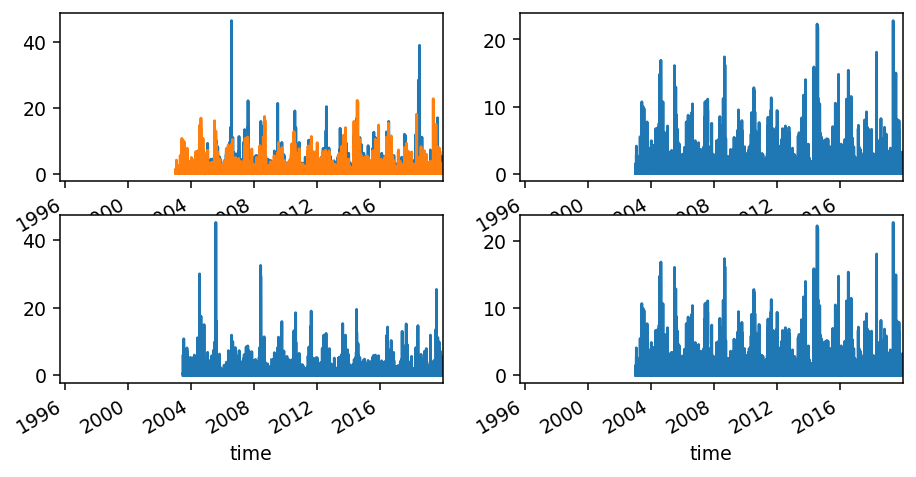

In [33]:
fig = plt.figure(dpi= 136, figsize=(8,4))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
df_merged_ts[216].plot(ax = ax1)
df_merged_ts[2110].plot(ax = ax1)
df_merged_ts[2110].plot(ax = ax2)
df_merged_ts[1590].plot(ax = ax3)
df_merged_ts[2110].plot(ax = ax4)
plt.show()

**Attention: The following code creates a heatmap. This makes only sense if the data density is low, e.g. annual temperatures. Do not use it for hourly precipitation over a long period.**

```
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plot
sns.set_style('ticks')
fig1, ax1 = plt.subplots(dpi = 400, figsize = (12,24))

#sns.heatmap(df_merged_ts, cmap='RdYlGn_r', annot=False, ax = ax1)
sns.heatmap(df_merged_ts, cmap='coolwarm', annot=True, vmin = 8, vmax = 12, ax = ax1)

# _r reverses the normal order of the color map 'RdYlGn'

#sns.heatmap(df, cmap='coolwarm', annot=True, vmin = 8, vmax = 12, ax = ax)
ax1.set_yticklabels(df_merged_ts.index.strftime('%Y'))
plt.show()
fig1.savefig('example1.png')
```

In [34]:
df_merged_ts_transposed = df_merged_ts.transpose()

In [35]:
df_merged_ts_transposed.index.names = ['station_id']

In [36]:
df_merged_ts_transposed.shape

(88, 213225)

In [37]:
df_merged_ts_transposed.head()

time,1995-09-01 00:00:00,1995-09-01 01:00:00,1995-09-01 02:00:00,1995-09-01 03:00:00,1995-09-01 04:00:00,1995-09-01 05:00:00,1995-09-01 06:00:00,1995-09-01 07:00:00,1995-09-01 08:00:00,1995-09-01 09:00:00,...,2019-12-31 14:00:00,2019-12-31 15:00:00,2019-12-31 16:00:00,2019-12-31 17:00:00,2019-12-31 18:00:00,2019-12-31 19:00:00,2019-12-31 20:00:00,2019-12-31 21:00:00,2019-12-31 22:00:00,2019-12-31 23:00:00
station_id,,,,,,,,,,,,,,,,,,,,,
216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
filepathname = local_ts_merged_dir + "prec_ts_merged_transposed.csv"
print("df_merged_ts_transposed is saved to: %s" % (filepathname))
df_merged_ts_transposed.to_csv(filepathname,sep=";")

df_merged_ts_transposed is saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_merged_transposed.csv


In [39]:
df_merged_ts_transposed.iloc[2,:4]

time
1995-09-01 00:00:00   NaN
1995-09-01 01:00:00   NaN
1995-09-01 02:00:00   NaN
1995-09-01 03:00:00   NaN
Name: 390, dtype: float64

In [40]:
df_merged_ts_transposed_last_day = df_merged_ts_transposed.iloc[:,-24:]

In [41]:
df_merged_ts_transposed_last_day.shape

(88, 24)

In [42]:
df_merged_ts_transposed_last_day.head()

time,2019-12-31 00:00:00,2019-12-31 01:00:00,2019-12-31 02:00:00,2019-12-31 03:00:00,2019-12-31 04:00:00,2019-12-31 05:00:00,2019-12-31 06:00:00,2019-12-31 07:00:00,2019-12-31 08:00:00,2019-12-31 09:00:00,...,2019-12-31 14:00:00,2019-12-31 15:00:00,2019-12-31 16:00:00,2019-12-31 17:00:00,2019-12-31 18:00:00,2019-12-31 19:00:00,2019-12-31 20:00:00,2019-12-31 21:00:00,2019-12-31 22:00:00,2019-12-31 23:00:00
station_id,,,,,,,,,,,,,,,,,,,,,
216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
filepathname = local_ts_merged_dir + "prec_ts_merged_transposed_last_day.csv"
print("df_merged_ts_transposed_last_day saved to: %s" % (filepathname))
df_merged_ts_transposed_last_day.to_csv(filepathname,sep=";")

df_merged_ts_transposed_last_day saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_merged_transposed_last_day.csv


In [44]:
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
# TEMPERATURE                dftmp = temp_ts_to_df(myfile)
# PRECIPIATION
                dftmp = prec_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
#                print(dftmp.head(5))
                df = df.append(dftmp)

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)
    return(df)

In [45]:
df_appended_ts = ts_append()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20191231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20191231_00216.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20191231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20191231_00389.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20191231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20191231_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00554_19950901_20191231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20191231_00554.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00555_20080101_20181101_hist.zip
Extract product file: produkt_rr_stunde_20080101_20181101_00555.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenw

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03540_20041101_20191231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20191231_03540.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03591_20040601_20191231_hist.zip
Extract product file: produkt_rr_stunde_20040601_20191231_03591.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03795_20041201_20191231_hist.zip
Extract product file: produkt_rr_stunde_20041201_20191231_03795.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03913_20040701_20191231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20191231_03913.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04063_20030701_20191231_hist.zip
Extract product file: produkt_rr_stunde_20030701_20191231_04063.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenw

In [46]:
df_appended_ts.shape

(11581404, 13)

In [47]:
df_appended_ts.head()

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2004-10-01 00:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 01:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 02:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 03:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 04:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen


In [48]:
#filepathname = local_ts_appended_dir + "prec_ts_appended.csv"
#print("df_appended_ts saved to: %s" % (filepathname))
#df_appended_ts.to_csv(filepathname,sep=";")

In [49]:
type(df_appended_ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [50]:
type(df_appended_ts.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [51]:
df0 = df_appended_ts[["stations_id","r1","longitude", "altitude", "latitude"]]
df0.head()

,stations_id,r1,longitude,altitude,latitude
mess_datum,,,,,
2004-10-01 00:00:00,216,0.0,7.8807,298,51.1143
2004-10-01 01:00:00,216,0.0,7.8807,298,51.1143
2004-10-01 02:00:00,216,0.0,7.8807,298,51.1143
2004-10-01 03:00:00,216,0.0,7.8807,298,51.1143
2004-10-01 04:00:00,216,0.0,7.8807,298,51.1143


In [52]:
# datetime.fromisoformat(...)

In [53]:
df_appended_ts[["stations_id","r1","altitude"]].head()

,stations_id,r1,altitude
mess_datum,,,
2004-10-01 00:00:00,216,0.0,298
2004-10-01 01:00:00,216,0.0,298
2004-10-01 02:00:00,216,0.0,298
2004-10-01 03:00:00,216,0.0,298
2004-10-01 04:00:00,216,0.0,298


In [54]:
df = df_appended_ts.copy(deep=True)

In [55]:
d3 = datetime.fromisoformat('2019-07-08 02:00:00')

In [56]:
type(d3)

datetime.datetime

In [57]:
idx = (df_appended_ts.index >= '2017-04-16 00:00:00') & (df_appended_ts.index < '2017-08-16 00:00:00') 

In [58]:
# df_appended_ts_April_to_Aug = df_appended_ts[idx][["stations_id","r1","longitude", "latitude"]]
df_appended_ts_April_to_Aug = df_appended_ts[idx][["stations_id","r1","altitude"]]

In [59]:
df_appended_ts_April_to_Aug.head()

,stations_id,r1,altitude
mess_datum,,,
2017-04-16 00:00:00,216,0.0,298
2017-04-16 01:00:00,216,0.1,298
2017-04-16 02:00:00,216,0.1,298
2017-04-16 03:00:00,216,0.0,298
2017-04-16 04:00:00,216,0.0,298


In [60]:
filepathname = local_ts_appended_dir + "prec_ts_appended_April_to_Aug.csv"
print("df_appended_ts_April_to_Aug saved to: %s" % (filepathname))
df_appended_ts_April_to_Aug.to_csv(filepathname,sep=";")

df_appended_ts_April_to_Aug saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_appended_April_to_Aug.csv


In [61]:
df_appended_ts_April_to_Aug.head()

,stations_id,r1,altitude
mess_datum,,,
2017-04-16 00:00:00,216,0.0,298
2017-04-16 01:00:00,216,0.1,298
2017-04-16 02:00:00,216,0.1,298
2017-04-16 03:00:00,216,0.0,298
2017-04-16 04:00:00,216,0.0,298


In [62]:
df.head()

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2004-10-01 00:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 01:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 02:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 03:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 04:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2021-03-27,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen


# Analyse cumulative precipitation vs altitude (DTM)

In [63]:
#storing all 13 counties stations in array
#st = [4127,13713,5619,6313,13700,3098,6276,5480,4400,5360,4313,7330,3031,934,4368,5699,3028,644,613,5347,6264,1300,4488,2483,3215,2947,216,5468,389,390,4692,3499,796]

st = [4127,13713,5619,6313,13700,3098,6276,5480,4400,5360,4313,7330,3031,934,4368,5699,3028,644,613,5347,6264,1300,4488,3215,2947,216,5468,389,390,4692,3499,796]


In [64]:
#Using pandas resample method to calculate the sum of precipitation for all 13 countie from time period 2017-04-16 to 2017-08-16
df_new = df_appended_ts_April_to_Aug.loc[df_appended_ts_April_to_Aug['stations_id'].isin(st)].reset_index().pivot(index='mess_datum', columns='stations_id', values=['r1']).resample('Y').sum()

In [65]:
#Drop unwanted mess_datum column 
df_st = df_new.reset_index().drop('mess_datum', axis=1)

D:\conda\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [66]:
#reset index and column
df_r1 = df_st.transpose()

In [67]:
#reset index
clean_df = df_r1.reset_index()

In [68]:
#renaming column
rain_df = clean_df.rename(columns={0: "rainfall"})

In [69]:
rain_df.head()

,level_0,stations_id,rainfall
0,r1,216,311.0
1,r1,389,333.3
2,r1,390,377.1
3,r1,613,392.3
4,r1,644,385.6


# Filtering station altitude from df_appended_ts_April_to_Aug dataframe

In [70]:
store_altitude = df_appended_ts_April_to_Aug

In [71]:
df_altitude = store_altitude.loc[store_altitude['stations_id'].isin(st)].groupby(['stations_id', 'altitude']).first().reset_index().drop('r1', axis=1)

In [72]:
df_altitude

,stations_id,altitude
0,216,298
1,389,436
2,390,610
3,613,206
4,644,150
5,796,412
6,934,88
7,1300,351
8,2947,286
9,3028,157


# Merging Rainfall and Altitude dataframes

In [73]:
result = pd.merge(rain_df, df_altitude)

In [74]:
#setting station id as index for graphical analysis
idx_st = result.set_index('stations_id')

# Graphical Analysis

In [75]:
import matplotlib.pyplot as plt
import seaborn as sb

In [76]:
sort_df = idx_st.sort_values(by=['altitude'])

In [77]:
sort_df.head()

,level_0,rainfall,altitude
stations_id,,,
5480,r1,285.4,85
934,r1,348.4,88
3031,r1,370.9,92
4368,r1,345.0,93
644,r1,385.6,150


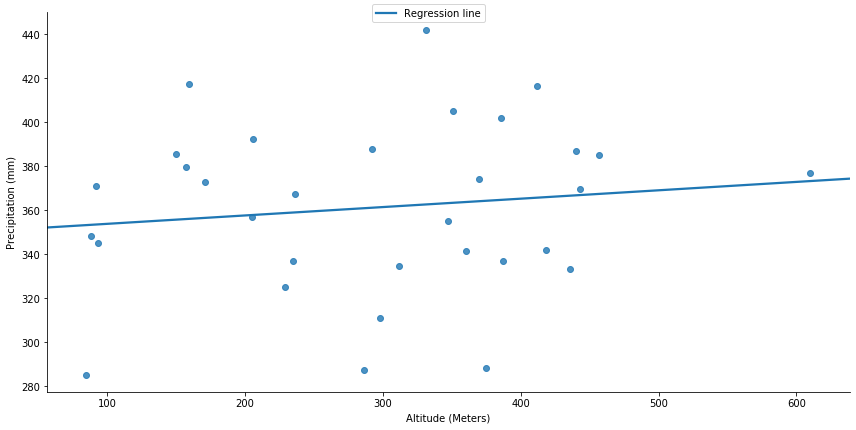

In [78]:
# use lmplot 
ax = sb.lmplot(x = "altitude", 
            y = "rainfall",  
            ci = None, 
            data = sort_df, height=6, aspect=2, legend=True)

ax.set(xlabel='Altitude (Meters)', ylabel='Precipitation (mm)')
ax.fig.legend(['Regression line'],loc="upper center")
plt.savefig('C:/Users/jilesh mehta/Pictures/figures_geoinfo/regression.png', dpi=500)

In [79]:
corr = sort_df.corr(method = 'pearson')

In [80]:
corr #yes there is a relation but not evident to conclude as the corr values in 0.39 (positive weak rel)

,rainfall,altitude
rainfall,1.000000,0.130254
altitude,0.130254,1.000000


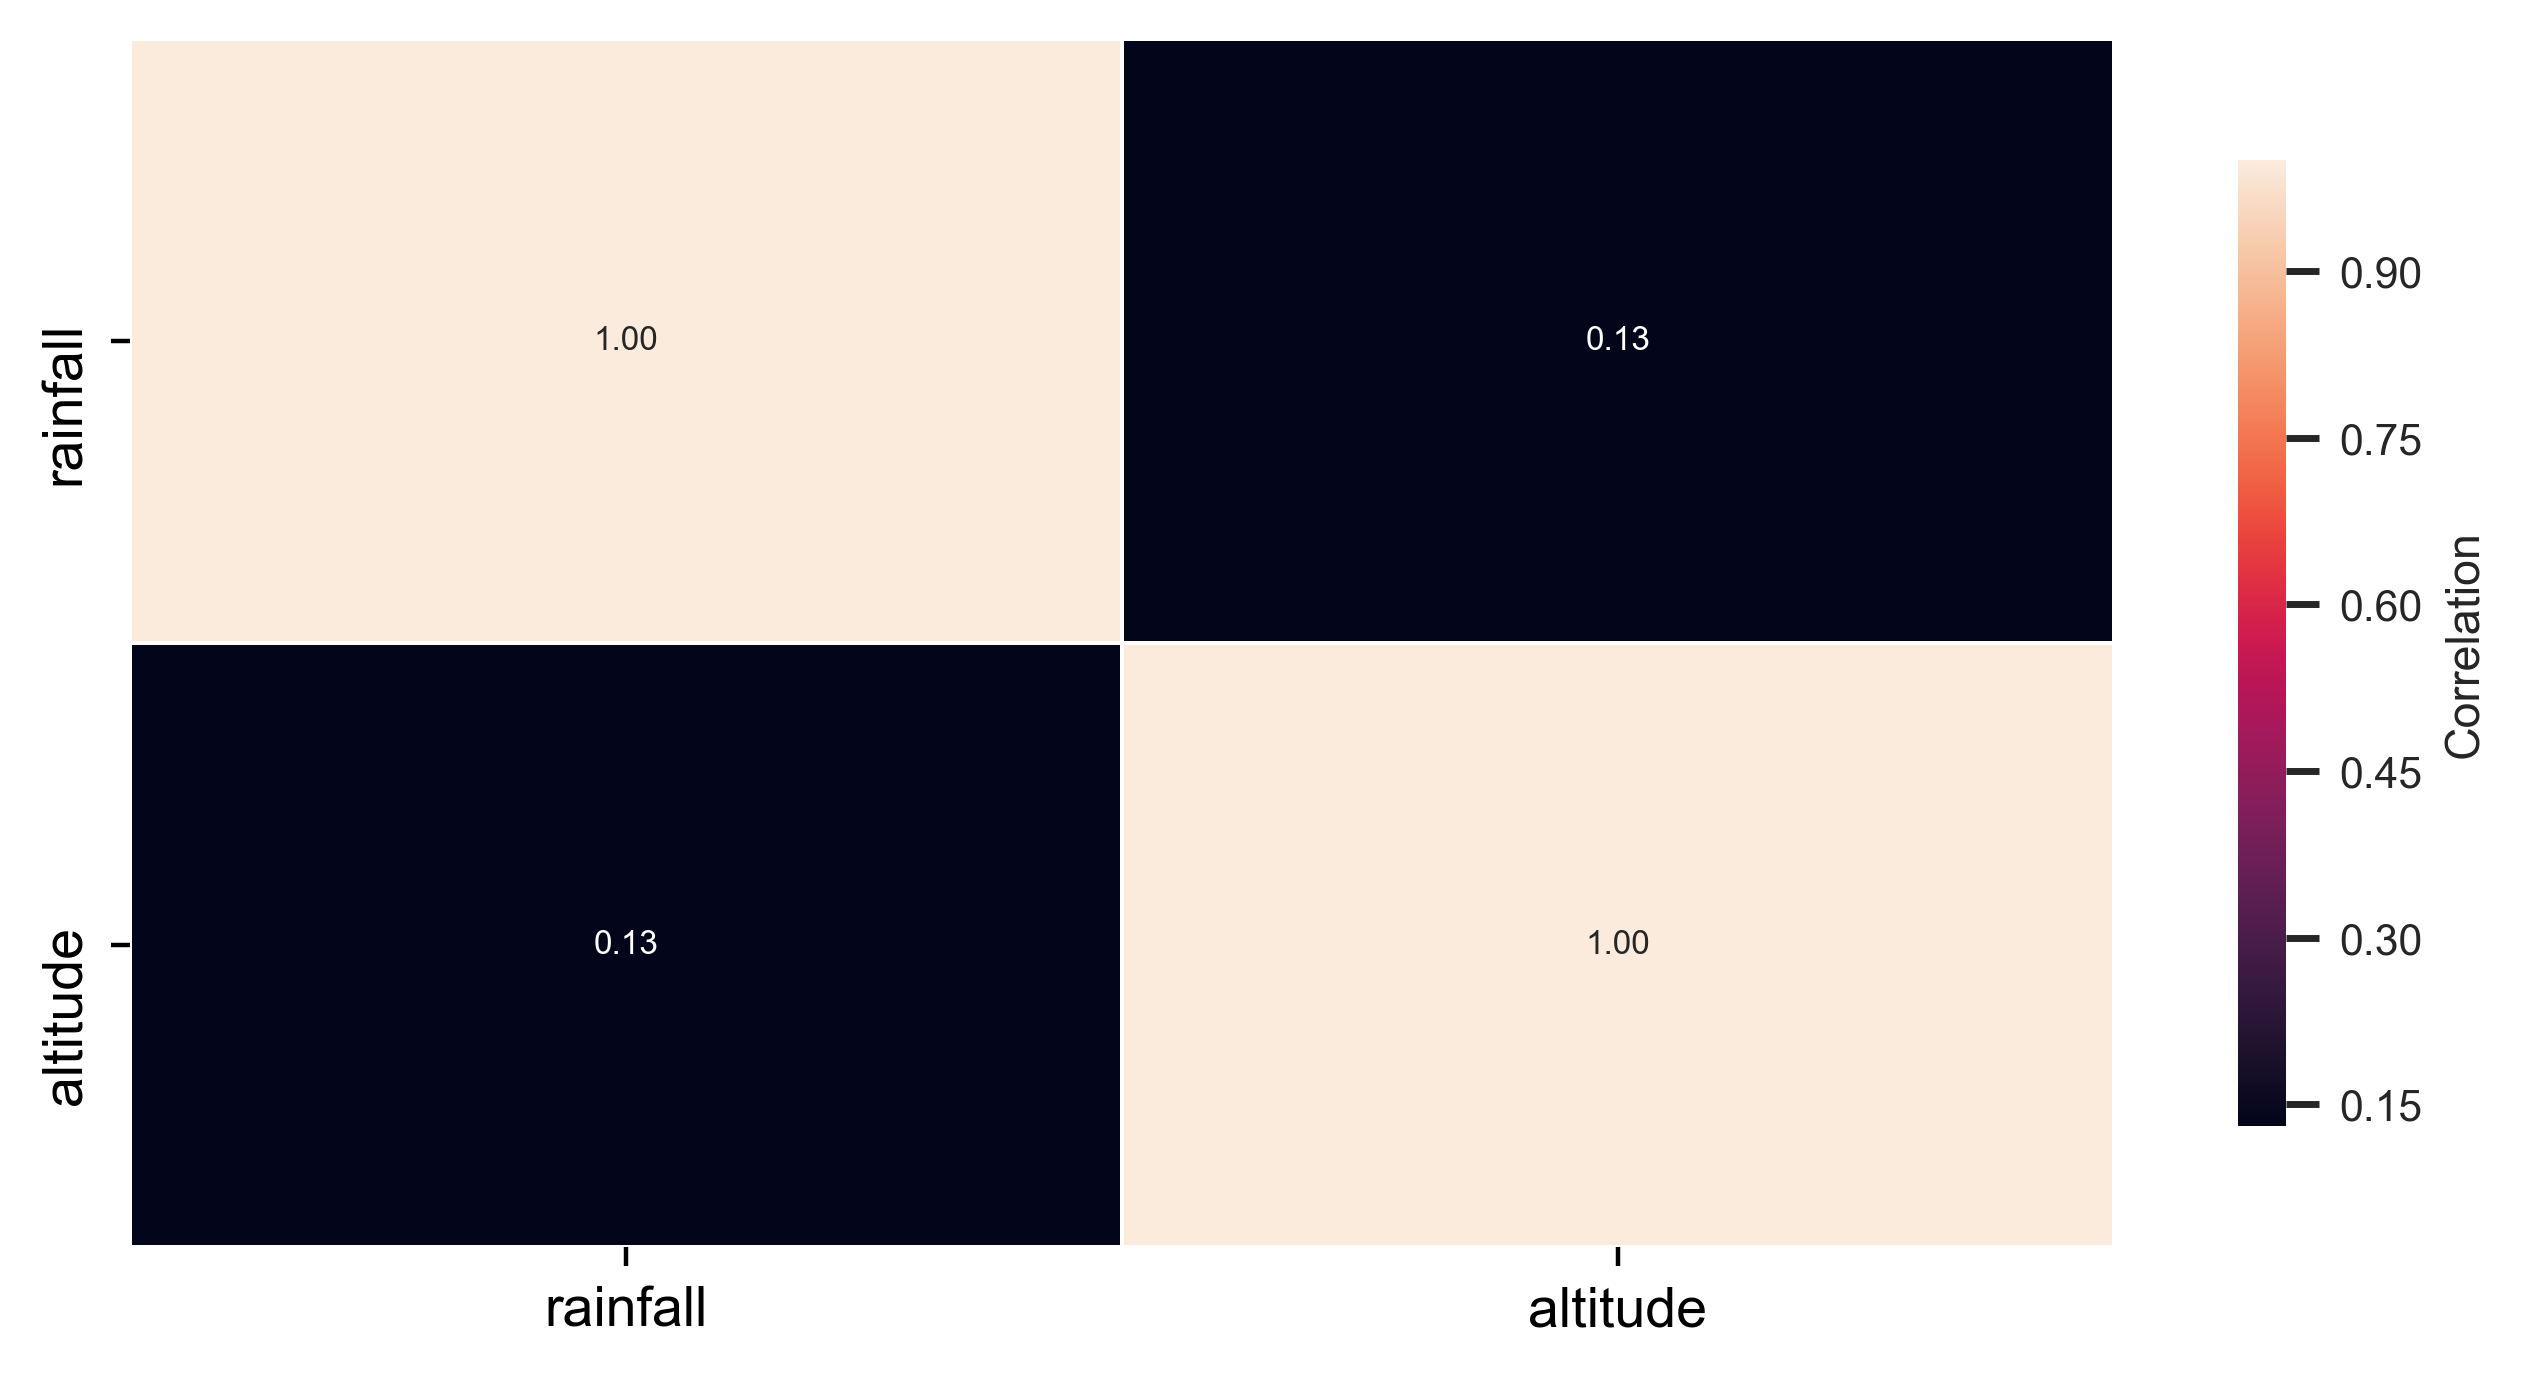

In [81]:
fig, ax = plt.subplots(dpi= 400, figsize=(8,4))
sb.set(font_scale=0.7)
ax = sb.heatmap(corr,
                 robust=True,
                 fmt='.2f',
                 annot=True,
                 linewidths=.5,
                 annot_kws={'size':6},
                 cbar_kws={'shrink':.8,
                           'label':'Correlation'}) 


#ax.set(xlabel="Station id", ylabel = "Time period from 2017-04-16 to 2017-08-16")
plt.savefig('C:/Users/jilesh mehta/Pictures/figures_geoinfo/corr.png', dpi=500)

<Figure size 2400x1600 with 0 Axes>

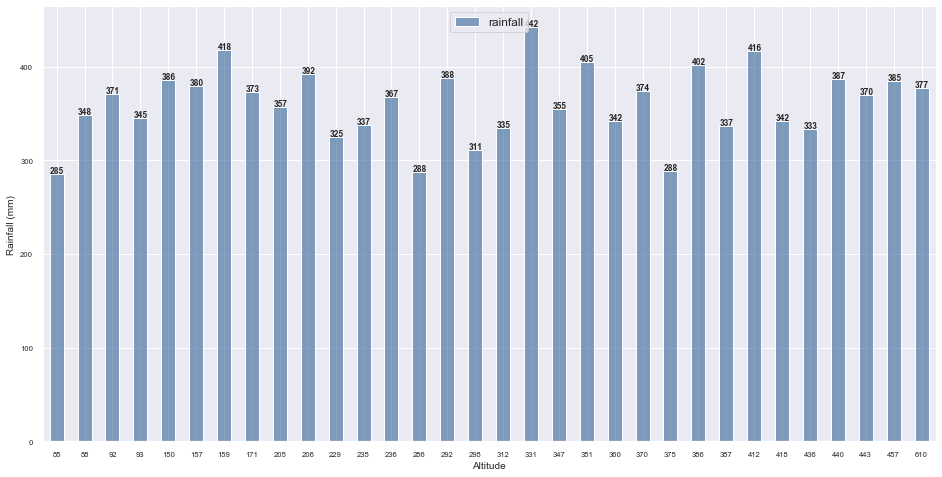

In [82]:
fig = plt.figure(dpi=400)
sort_df.plot.bar(x='altitude',y='rainfall', figsize=(16,8), color=(0.2, 0.4, 0.6, 0.6))
for i, number in enumerate(sort_df['rainfall']):
    plt.text(x=i-.23, y=number + 0.9, s=round(number), weight='bold')
plt.xticks(rotation=0)
plt.legend(['rainfall'], loc="upper center", fontsize=12)
plt.xlabel("Altitude", fontsize=10)
plt.ylabel("Rainfall (mm)", fontsize=10)
#plt.savefig('C:/Users/jilesh mehta/Pictures/figures_geoinfo/altibar.png', dpi=500)
plt.show()

In [83]:
import pandas as pd

#importing CSV containing DTM and precipitation station altitude
df = pd.read_csv("C:/Users/jilesh mehta/Pictures/figures_geoinfo/april_to_aug_DTM_altitude_Bar_Chart.csv",sep=",").rename(columns={"Prec_Station Altitude": "Prec_Altitude"})

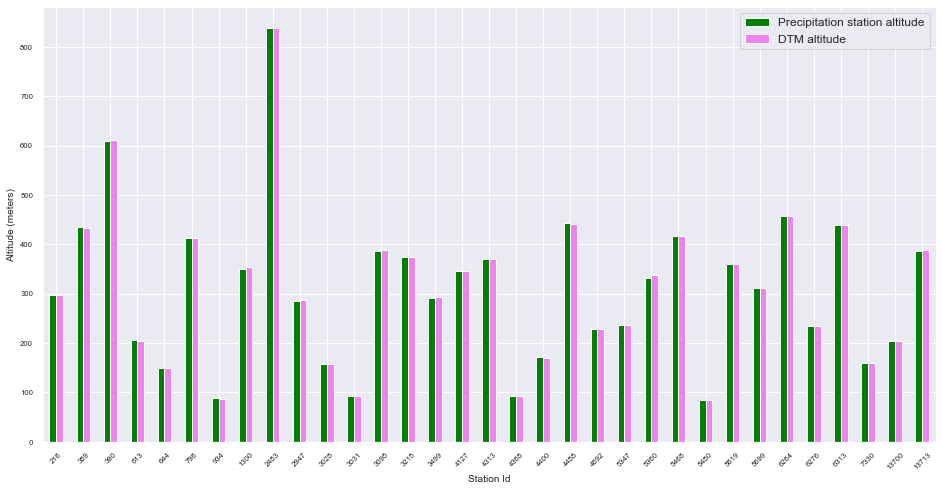

In [97]:
ax = df.set_index('stations_id')[['Prec_Altitude', 'DTM_Altitude']].plot.bar(color = ['green','violet'], figsize=(16,8), rot=45)
#plt.legend(['rainfall'], loc="upper center", fontsize=12)
ax.legend(['Precipitation station altitude', 'DTM altitude'], loc="upper right", fontsize=12)
plt.xlabel("Station Id", fontsize=10)
plt.ylabel("Altitude (meters)", fontsize=10)
plt.savefig('C:/Users/jilesh mehta/Pictures/figures_geoinfo/dtm_prec_altitude.png', dpi=500)
plt.show()